### Universidad de Granada | ETSIIT | Escuela Internacional de Posgrado
---
# **Proyecto Final**: Naïve Bayes
---
**Asignatura:** Minería de Datos: Preprocesamiento y Clasificación

**Autor:** Lugli, Valentino Glauco · YB0819879

# Librerías y Datos

In [105]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy import stats
from tabulate import tabulate
import pickle

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, KBinsDiscretizer
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif
from sklearn.neighbors import LocalOutlierFactor



from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [133]:
df_credit = pd.read_csv("../data_preprocess/train_preprocess.csv").drop(columns=["ID"])

df_credit_x = df_credit.drop(columns=["RATE"])
df_credit_y = df_credit["RATE"]

df_test = pd.read_csv("../data_preprocess/test_preprocess.csv")
X_test     = df_test.drop(columns=["ID"])
X_test_ids = df_test["ID"]

In [134]:
X_train, X_val, y_train, y_val= train_test_split(df_credit_x, 
                                                   df_credit_y, stratify=df_credit_y, 
                                                   test_size=0.2, 
                                                   random_state=16)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns=df_credit_x.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=df_credit_x.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=df_credit_x.columns)

# minmax = MinMaxScaler()
# minmax.fit(X_train)

# X_train = minmax.transform(X_train)
# X_val = minmax.transform(X_val)

# Preprocesado

## Funciones

In [38]:
def naive_bayes_fits(results, x_train, y_train, x_test, y_test, show_cf = True):
    best_acc = -1
    body   = []
    for model in results:

        y_pred_train = results[model]["model"].fit(x_train, y_train).predict(x_train)
        y_pred_test  = results[model]["model"].predict(x_test)
        results[model]["train"] = classification_report(y_train, y_pred_train, output_dict=True, zero_division=0)
        results[model]["test"]  = classification_report(y_test, y_pred_test, output_dict=True, zero_division=0)
        results[model]["test_pred"]  = y_pred_test
        results[model]["train_pred"]  = y_pred_train
        act_acc = results[model]["test"]["accuracy"]

        body.append([model, results[model]["train"]["accuracy"] * 100, results[model]["test"]["accuracy"] * 100])
        if act_acc > best_acc:
            best_acc = act_acc

    # print(tabulate(body, headers=header, floatfmt=".4f"))
    naive_bayes_stats(results, y_test, show_cf=show_cf)

    return results

def naive_bayes_stats(results, y_test, show_cf = True):
    
    header = ["Variant", "F1 Score", "Train Acc", "Test Acc"]
    body = []
    matrices = []

    for m in results:
        body.append([m, results[m]["test"]["macro avg"]["f1-score"], results[m]["train"]["accuracy"] * 100, results[m]["test"]["accuracy"] * 100])
        matrices.append(confusion_matrix(y_test, results[m]["test_pred"]))
    print(tabulate(body, headers=header, floatfmt=".4f"))

    if(show_cf):
        fig, axes = plt.subplots(nrows=1, ncols=len(matrices), figsize=(18, 4))

        tick_labels = ["A", "B", "C", "D"]

        if(len(matrices) > 1):
            axes = axes.flatten()
        else:
            curr_ax = axes

        for i, model in enumerate(results):
            if(len(matrices) > 1):
                curr_ax = axes[i]

            sns.heatmap(matrices[i], ax=curr_ax, annot=True, xticklabels=tick_labels, yticklabels=tick_labels)
            curr_ax.title.set_text(model)
            curr_ax.set_xlabel("Predicted") 
            curr_ax.set_ylabel("Real") 

        plt.tight_layout()
        plt.show()


def get_kaggle_pred(model, data, id, path=".", fname="kaggle_out",):
    model_pred = model.predict(data)
    kaggle_dict = {"ID" : id, "RATE" : model_pred}
    pd.DataFrame(data=kaggle_dict).to_csv("{}/{}.csv".format(path, fname), index=False)

In [127]:
def set_scaler(scaler, X_train_in, X_val_in, X_test_in):
    scaler.fit(X_train_in)

    X_train_out = pd.DataFrame(scaler.transform(X_train_in), columns=X_train_in.columns)
    X_val_out   = pd.DataFrame(scaler.transform(X_val_in), columns=X_train_in.columns)
    X_test_out  = pd.DataFrame(scaler.transform(X_test_in), columns=X_train_in.columns)

    return X_train_out, X_val_out, X_test_out


def set_PCA(X_train_in, X_val_in, X_test_in, ratio):
    explained_variance_ratio = 0
    i = 0
    while(explained_variance_ratio < ratio):
        i += 1
        pca = PCA(n_components=i)
        pca.fit(X_train_in)
        explained_variance_ratio = np.sum(pca.explained_variance_ratio_)

    X_train_out = pd.DataFrame(pca.transform(X_train_in))
    X_val_out   = pd.DataFrame(pca.transform(X_val_in))
    X_test_out  = pd.DataFrame(pca.transform(X_test_in))

    return X_train_out, X_val_out, X_test_out

def discretize(X_train_in, X_val_in, X_test_in, bins, enconder, strat):
    discretizer = KBinsDiscretizer(n_bins=bins, encode=enconder, strategy=strat)

    X_train_out = pd.DataFrame(discretizer.fit_transform(X_train_in), columns=discretizer.get_feature_names_out())
    X_val_out   = pd.DataFrame(discretizer.transform(X_val_in), columns=discretizer.get_feature_names_out())
    X_test_out  = pd.DataFrame(discretizer.transform(X_test_in), columns=discretizer.get_feature_names_out())

    return X_train_out, X_val_out, X_test_out
 
def feature_perc(X_train_in, y_train_in, X_val_in, X_test_in, percent):
    fs = SelectPercentile(score_func=f_classif, percentile=percent)

    X_train_out = fs.fit_transform(X_train_in, y_train_in)
    X_val_out   = fs.transform(X_val_in)
    X_test_out  = fs.transform(X_test_in)

    return X_train_out, X_val_out, X_test_out

def feature_top(X_train_in, y_train, X_val_in, X_test_in, k):
    fs = SelectKBest(score_func=f_classif, k=k)

    X_train_out = fs.fit_transform(X_train_in, y_train)
    X_val_out   = fs.transform(X_val_in)
    X_test_out  = fs.transform(X_test_in)

    return X_train_out, X_val_out, X_test_out

def get_lof(X_train_in, y_train, neigh):
    lof = LocalOutlierFactor(n_neighbors=neigh)
    yhat = lof.fit_predict(X_train_in)

    mask = yhat != -1
    X_train_out, y_train_out = X_train[mask, :], y_train[mask]  

    return X_train_out, y_train_out

def down_sample(X_train_in, y_train_in, neigh):
    X_train_out, y_train_out = NearMiss(version=2, n_neighbors=neigh).fit_resample(X_train_in, y_train_in)

    return X_train_out, y_train_out

def up_sample(X_train_in, y_train_in, neigh):
    sm = SMOTE(random_state=16, k_neighbors=neigh)
    X_train_out, y_train_out = sm.fit_resample(X_train_in, y_train_in)

    return X_train_out, y_train_out

def get_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    # print('Correlated Columns are: {}'.format(sorted(drops)))
    return drops

def delete_corr(X_train_in, X_val_in, X_test_in, corr_val):
    collinear_cols = get_collinear_features(X_train_in, corr_val)
    X_train_out = X_train_in.drop(columns=collinear_cols)
    X_val_out   = X_val_in.drop(columns=collinear_cols)
    X_test_out  = X_test_in.drop(columns=collinear_cols)

    return X_train_out, X_val_out, X_test_out

## Datos Originales

In [96]:
results = {
    "gaussian" : {"model" : GaussianNB()},
    # "multinom" : {"model" : MultinomialNB(force_alpha=True)},
    # "complement" : {"model" : ComplementNB(force_alpha=True)},
    # "bernoulli" : {"model" : BernoulliNB(force_alpha=True)},
    # "categorical_1" : {"model" : CategoricalNB(force_alpha=True)},
    # "categorical_2" : {"model" : CategoricalNB(force_alpha=True, fit_prior=False)},
    # "categorical_4" : {"model" : CategoricalNB(force_alpha=True, alpha=0.75)}
}

In [115]:
X_train, X_val, X_test = set_PCA(X_train, X_val, X_test, 0.7)

Variant      F1 Score    Train Acc    Test Acc
---------  ----------  -----------  ----------
gaussian       0.4588      58.5635     54.9451


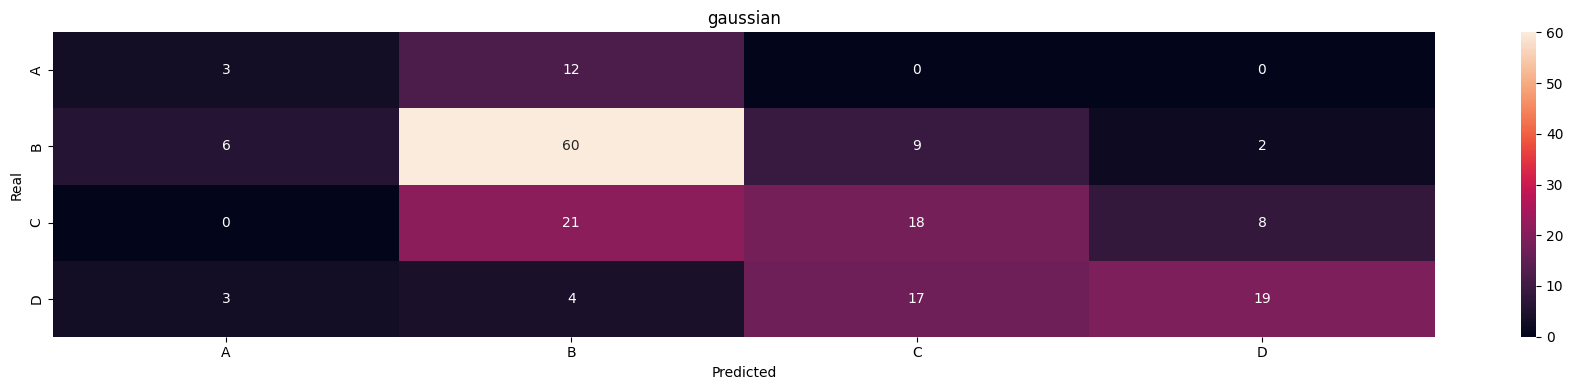

In [116]:
res_og = naive_bayes_fits(results, X_train, y_train, X_val, y_val)

In [135]:
X_train, X_val, X_test = discretize(X_train, X_val, X_test, 30, enconder="onehot-dense", strat="uniform")

/media/valentino/Irithyll1/repos/ClubFansIris/env/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


In [68]:
get_kaggle_pred(out["categorical_1"]["model"], X_test, X_test_ids, fname="nb_categorical__raw")

In [104]:
out["categorical_1"]["model"]

CategoricalNB(force_alpha=True)

In [106]:

# open a file, where you ant to store the data
file = open('best_categorical.pkl', 'wb')

# dump information to that file
pickle.dump(out["categorical_1"]["model"], file)

# close the file
file.close()

In [ ]:
pickle.dump(out["categorical_1"]["model"])

## Datos Remuestrados

### Undersampling

In [ ]:
df_under_x, df_under_y = NearMiss().fit_resample(df_credit_x, df_credit_y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_under_x, 
                                                    df_under_y, stratify=df_under_y, 
                                                    test_size=0.2, 
                                                    random_state=16)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

minmax = MinMaxScaler()
minmax.fit(X_train)

X_train = minmax.transform(X_train)
X_test = minmax.transform(X_test)

Variant       F1 Score    Train Acc    Test Acc
----------  ----------  -----------  ----------
gaussian        0.2673      43.7788     27.2727
multinom        0.1730      36.8664     20.0000
complement      0.2337      38.2488     25.4545
bernoulli       0.2284      39.6313     23.6364


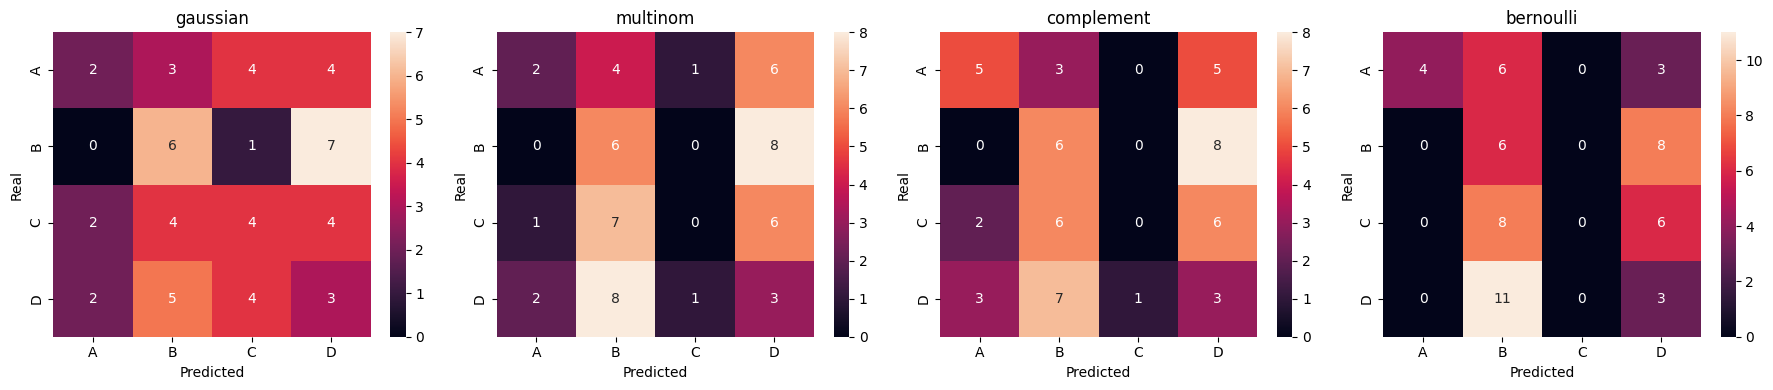

In [ ]:
res_og = naive_bayes_fits(X_train, y_train, X_test, y_test)

(272, 10)
Variant       F1 Score    Train Acc    Test Acc
----------  ----------  -----------  ----------
gaussian        0.2089      33.6406     23.6364
multinom        0.1999      30.4147     21.8182
complement      0.2261      30.8756     25.4545
bernoulli       0.1014      27.1889     25.4545


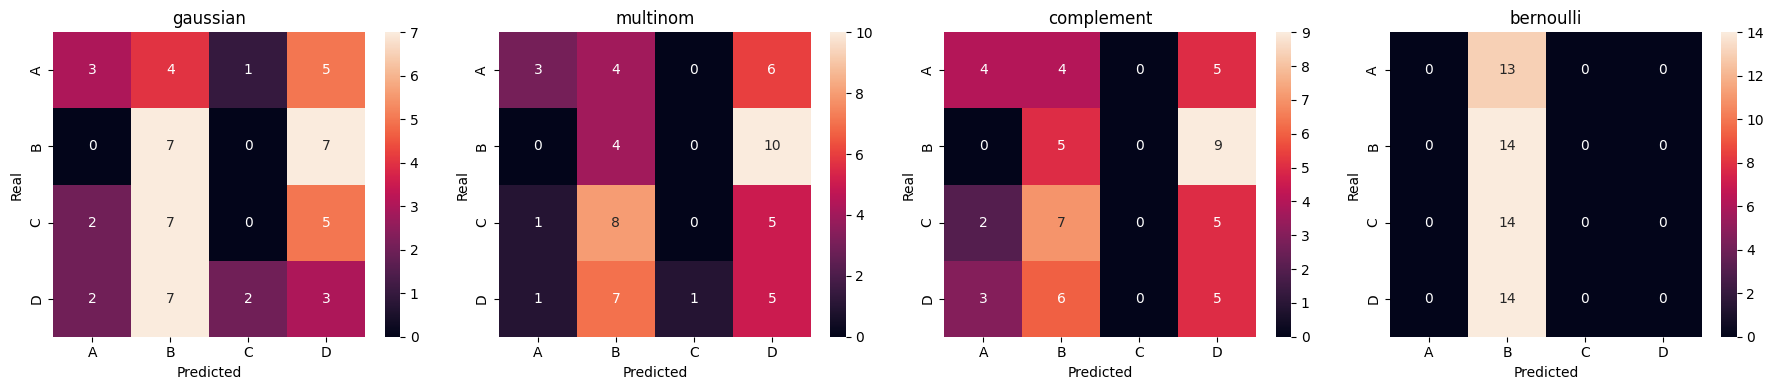

In [ ]:
fs = SelectPercentile(score_func=f_classif, percentile=25)
X_selected = fs.fit_transform(df_under_x, df_under_y)
print(X_selected.shape)

X_train, X_test, y_train, y_test = train_test_split(X_selected, 
                                                    df_under_y, stratify=df_under_y, 
                                                    test_size=0.2, 
                                                    random_state=16)
res = naive_bayes_fits(X_train, y_train, X_test, y_test)

### Oversampling

In [ ]:
# Resample the data
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(df_credit_x, df_credit_y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_res, 
                                                    y_res, stratify=y_res, 
                                                    test_size=0.2, 
                                                    random_state=16)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

minmax = MinMaxScaler()
minmax.fit(X_train)

X_train = minmax.transform(X_train)
X_test = minmax.transform(X_test)

Variant       F1 Score    Train Acc    Test Acc
----------  ----------  -----------  ----------
gaussian        0.1648      27.6190     23.8754
multinom        0.1892      26.4069     24.2215
complement      0.1935      26.2338     24.5675
bernoulli       0.1572      29.3506     27.3356


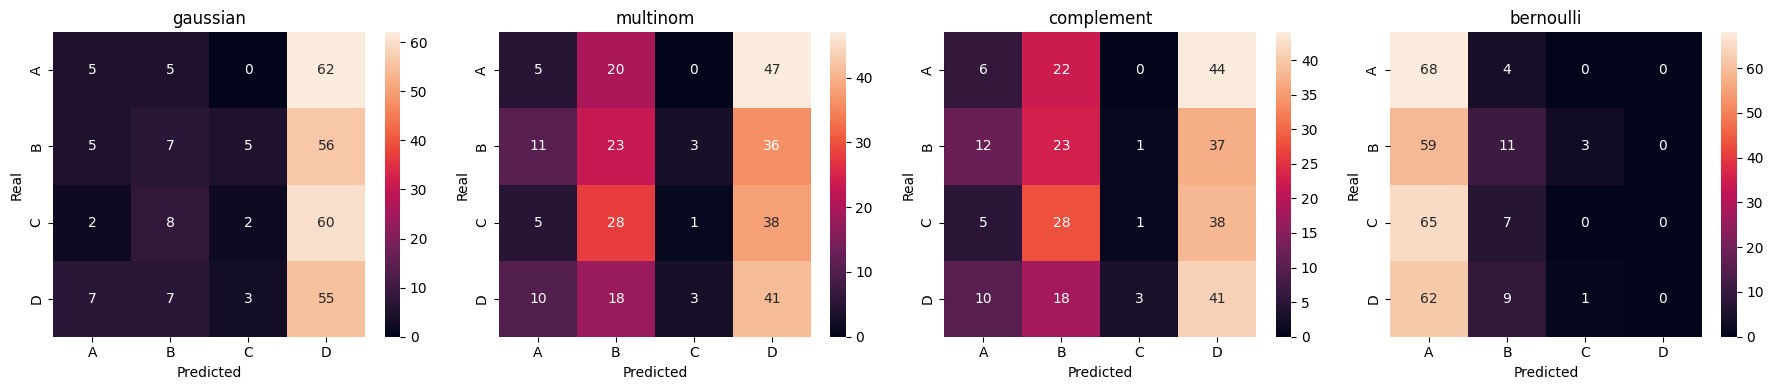

In [ ]:
res_og = naive_bayes_fits(X_train, y_train, X_test, y_test)

(1444, 10)
Variant       F1 Score    Train Acc    Test Acc
----------  ----------  -----------  ----------
gaussian        0.2009      28.2251     28.0277
multinom        0.2922      30.2165     32.8720
complement      0.2704      30.2165     31.1419
bernoulli       0.1195      26.1472     25.6055


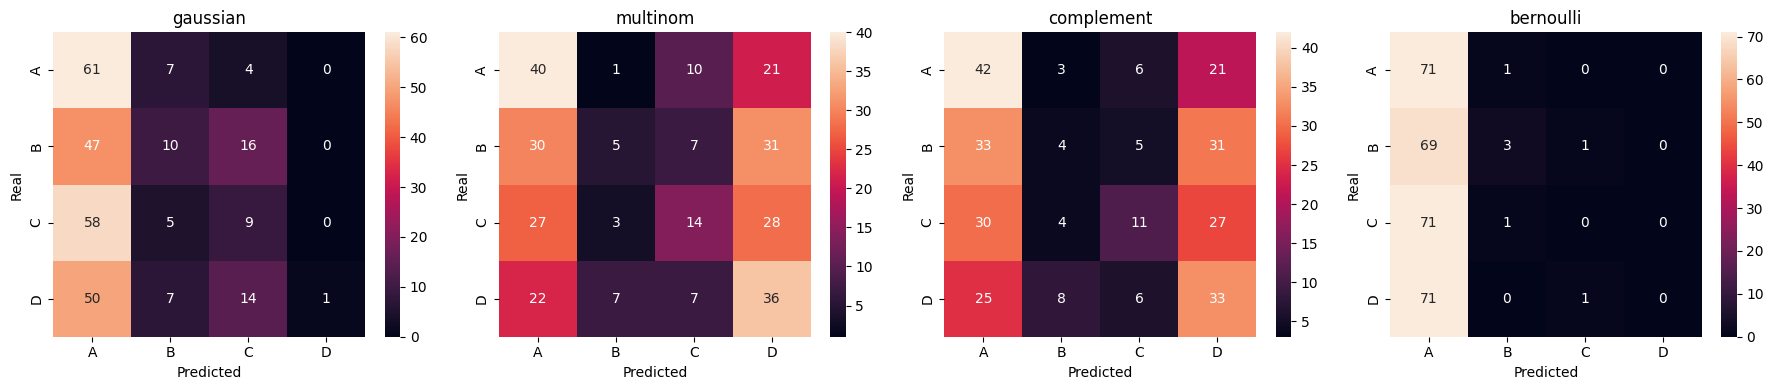

In [ ]:
fs = SelectPercentile(score_func=f_classif, percentile=25)
X_selected = fs.fit_transform(X_res, y_res)
print(X_selected.shape)

X_train, X_test, y_train, y_test = train_test_split(X_selected, 
                                                    y_res, stratify=y_res, 
                                                    test_size=0.2, 
                                                    random_state=16)
res = naive_bayes_fits(X_train, y_train, X_test, y_test)

With 8 components the PCA retains 99.0094% of the original variance.
Variant       F1 Score    Train Acc    Test Acc
----------  ----------  -----------  ----------
gaussian        0.3126      34.1991     33.9100
multinom        0.3496      31.6883     36.6782
complement      0.3596      31.6883     37.3702
bernoulli       0.0997      25.7143     24.9135


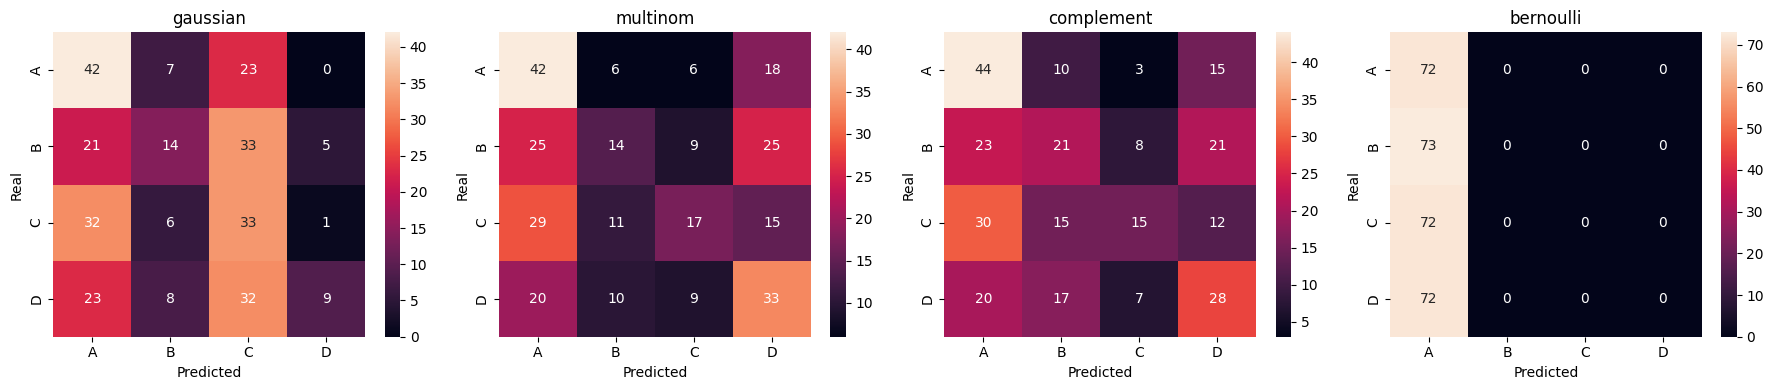

In [ ]:
explained_variance_ratio = 0
i = 0
while(explained_variance_ratio < 0.99):
    i += 1
    pca = PCA(n_components=i)
    pca.fit(X_train)
    explained_variance_ratio = np.sum(pca.explained_variance_ratio_)

print("With {} components the PCA retains {:.4f}% of the original variance.".format(i, (explained_variance_ratio*100)))

X_train = pca.fit_transform(X_train)
x_test  = pca.transform(X_test)

pca_minmax = MinMaxScaler(feature_range=(0,1))
pca_minmax.fit(X_train)
X_train_pca = pca_minmax.transform(X_train)
X_test_pca = pca_minmax.transform(x_test)

res = naive_bayes_fits(X_train_pca, y_train, X_test_pca, y_test)

X2 | X1 | 0.97
X3 | X1 | 0.99
X3 | X2 | 0.98
X4 | X1 | 0.95
X4 | X2 | 0.92
X4 | X3 | 0.96
X5 | X1 | 0.97
X5 | X2 | 0.93
X5 | X3 | 0.95
X5 | X4 | 0.93
X6 | X1 | 0.97
X6 | X2 | 0.97
X6 | X3 | 0.98
X6 | X4 | 0.96
X6 | X5 | 0.94
X7 | X1 | 0.98
X7 | X2 | 0.95
X7 | X3 | 0.96
X7 | X4 | 0.88
X7 | X5 | 0.95
X7 | X6 | 0.92
X8 | X1 | 0.72
X8 | X2 | 0.72
X8 | X3 | 0.75
X8 | X4 | 0.75
X8 | X5 | 0.69
X8 | X6 | 0.75
X8 | X7 | 0.64
X10 | X1 | 0.91
X10 | X2 | 0.91
X10 | X3 | 0.92
X10 | X4 | 0.93
X10 | X5 | 0.9
X10 | X6 | 0.95
X10 | X7 | 0.86
X10 | X8 | 0.8
X11 | X1 | 0.79
X11 | X2 | 0.8
X11 | X3 | 0.81
X11 | X4 | 0.86
X11 | X5 | 0.79
X11 | X6 | 0.87
X11 | X7 | 0.71
X11 | X8 | 0.77
X11 | X10 | 0.92
X16 | X15 | 0.58
X17 | X15 | 0.52
X17 | X16 | 0.76
X18 | X15 | 0.61
X18 | X16 | 0.92
X18 | X17 | 0.76
X21 | X15 | 0.67
X21 | X16 | 0.54
X21 | X18 | 0.6
X22 | X15 | 0.82
X22 | X16 | 0.63
X22 | X17 | 0.58
X22 | X18 | 0.69
X22 | X21 | 0.75
X27 | X14 | 0.67
X27 | X25 | 0.72
X28 | X14 | 0.67
X28 | X27 | 0.55
X32 |

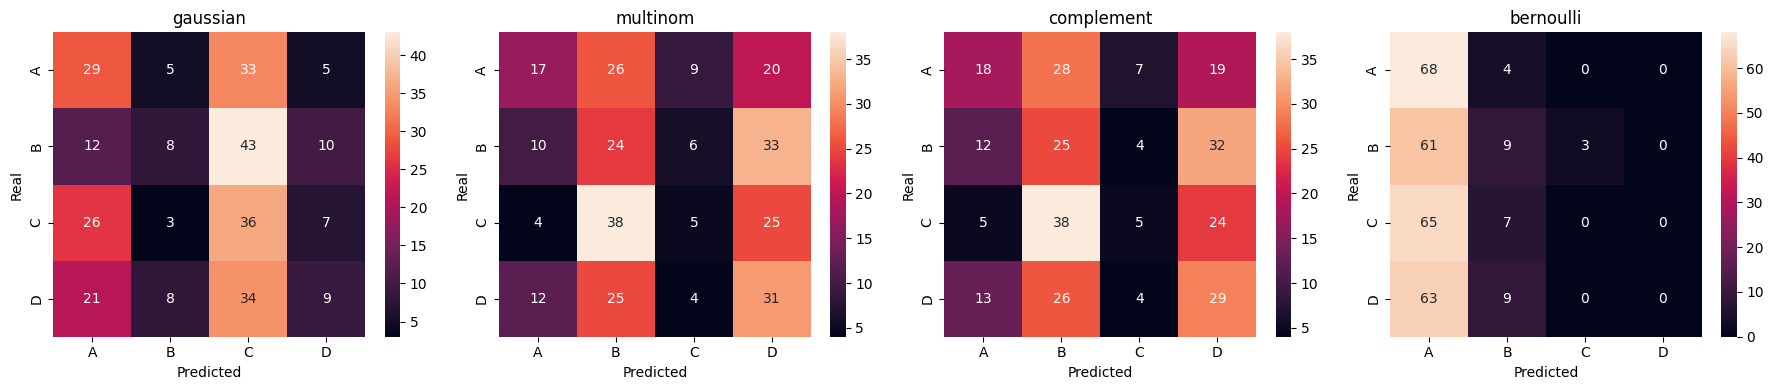

In [ ]:
collinear_cols = get_collinear_features(X_res, 0.5)
X_train_nonc = pd.DataFrame(X_train, columns=X_res.columns).drop(columns=collinear_cols)
X_test_nonc  = pd.DataFrame(X_test, columns=X_res.columns).drop(columns=collinear_cols)

res = naive_bayes_fits(X_train_nonc, y_train, X_test_nonc, y_test)

# Panic Testing...

# DISCRETO

In [9]:
collinear_cols = get_collinear_features(X_train, 0.5)
X_train = X_train.drop(columns=collinear_cols)
X_test  = X_test.drop(columns=collinear_cols)

X2 | X1 | 0.94
X3 | X1 | 0.98
X3 | X2 | 0.96
X4 | X1 | 0.94
X4 | X2 | 0.9
X4 | X3 | 0.95
X5 | X1 | 0.92
X5 | X2 | 0.84
X5 | X3 | 0.88
X5 | X4 | 0.86
X6 | X1 | 0.91
X6 | X2 | 0.9
X6 | X3 | 0.91
X6 | X4 | 0.89
X6 | X5 | 0.86
X7 | X1 | 0.97
X7 | X2 | 0.91
X7 | X3 | 0.94
X7 | X4 | 0.86
X7 | X5 | 0.91
X7 | X6 | 0.86
X8 | X1 | 0.61
X8 | X2 | 0.63
X8 | X3 | 0.65
X8 | X4 | 0.64
X8 | X5 | 0.54
X8 | X6 | 0.64
X8 | X7 | 0.55
X10 | X1 | 0.72
X10 | X2 | 0.7
X10 | X3 | 0.71
X10 | X4 | 0.72
X10 | X5 | 0.73
X10 | X6 | 0.86
X10 | X7 | 0.68
X10 | X8 | 0.61
X11 | X1 | 0.61
X11 | X2 | 0.61
X11 | X3 | 0.61
X11 | X4 | 0.66
X11 | X5 | 0.63
X11 | X6 | 0.8
X11 | X7 | 0.53
X11 | X8 | 0.55
X11 | X10 | 0.92
X16 | X15 | 0.51
X17 | X16 | 0.6
X18 | X15 | 0.55
X18 | X16 | 0.91
X18 | X17 | 0.56
X21 | X15 | 0.62
X21 | X18 | 0.53
X22 | X15 | 0.75
X22 | X16 | 0.57
X22 | X18 | 0.65
X22 | X21 | 0.73
X27 | X14 | 0.66
X27 | X25 | 0.7
X28 | X14 | 0.54
X32 | X14 | 0.82
X32 | X15 | 0.52
X32 | X27 | 0.61
X32 | X28 | 0.7
X33 | X1

In [94]:
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [98]:
explained_variance_ratio = 0
i = 0
while(explained_variance_ratio < 0.8):
    i += 1
    pca = PCA(n_components=i)
    pca.fit(X_train)
    explained_variance_ratio = np.sum(pca.explained_variance_ratio_)

print("With {} components the PCA retains {:.4f}% of the original variance.".format(i, (explained_variance_ratio*100)))

X_train = pca.transform(X_train)
X_val   = pca.transform(X_val)
X_test  = pca.transform(X_test)

With 11 components the PCA retains 81.8108% of the original variance.


In [80]:
X_train, y_train = NearMiss(version=2).fit_resample(X_train, y_train)

In [16]:
fs = SelectPercentile(score_func=f_classif, percentile=25)
X_train = fs.fit_transform(X_train, y_train)
X_test  = fs.transform(X_test)

In [86]:
discretizer = KBinsDiscretizer(n_bins=30, encode="onehot-dense", strategy="quantile")
X_train = discretizer.fit_transform(X_train)
X_val   = discretizer.transform(X_val)
X_test  = discretizer.transform(X_test)

In [87]:
X_train = discretizer.fit_transform(X_train)
X_val   = discretizer.transform(X_val)
X_test  = discretizer.transform(X_test)

In [88]:
discretizer.get_feature_names_out()

array(['x0_0.0', 'x0_1.0', 'x0_2.0', 'x0_3.0', 'x0_4.0', 'x0_5.0',
       'x0_6.0', 'x0_7.0', 'x0_8.0', 'x0_9.0', 'x0_10.0', 'x0_11.0',
       'x0_12.0', 'x0_13.0', 'x0_14.0', 'x0_15.0', 'x0_16.0', 'x0_17.0',
       'x0_18.0', 'x0_19.0', 'x0_20.0', 'x0_21.0', 'x0_22.0', 'x0_23.0',
       'x0_24.0', 'x0_25.0', 'x0_26.0', 'x0_27.0', 'x0_28.0', 'x0_29.0',
       'x1_0.0', 'x1_1.0', 'x1_2.0', 'x1_3.0', 'x1_4.0', 'x1_5.0',
       'x1_6.0', 'x1_7.0', 'x1_8.0', 'x1_9.0', 'x1_10.0', 'x1_11.0',
       'x1_12.0', 'x1_13.0', 'x1_14.0', 'x1_15.0', 'x1_16.0', 'x1_17.0',
       'x1_18.0', 'x1_19.0', 'x1_20.0', 'x1_21.0', 'x1_22.0', 'x1_23.0',
       'x1_24.0', 'x1_25.0', 'x1_26.0', 'x1_27.0', 'x1_28.0', 'x1_29.0',
       'x2_0.0', 'x2_1.0', 'x2_2.0', 'x2_3.0', 'x2_4.0', 'x2_5.0',
       'x2_6.0', 'x2_7.0', 'x2_8.0', 'x2_9.0', 'x2_10.0', 'x2_11.0',
       'x2_12.0', 'x2_13.0', 'x2_14.0', 'x2_15.0', 'x2_16.0', 'x2_17.0',
       'x2_18.0', 'x2_19.0', 'x2_20.0', 'x2_21.0', 'x2_22.0', 'x2_23.0',
       '

In [136]:
results = {
    # "gaussian" : {"model" : GaussianNB()},
    # "multinom" : {"model" : MultinomialNB(force_alpha=True)},
    # "complement" : {"model" : ComplementNB(force_alpha=True)},
    # "bernoulli" : {"model" : BernoulliNB(force_alpha=True)},
    "categorical_1" : {"model" : CategoricalNB(force_alpha=True)},
    # "categorical_2" : {"model" : CategoricalNB(force_alpha=True, fit_prior=False)},
    # "categorical_4" : {"model" : CategoricalNB(force_alpha=True, alpha=0.75)}
}

In [137]:
out = naive_bayes_fits(results, X_train, y_train, X_val, y_val)

IndexError: index 1 is out of bounds for axis 1 with size 1